# STEP 2: MODEL TRAINING & EVALUATION
## PJM Energy Forecasting — RNN, LSTM, Bi-LSTM, Encoder-Decoder

This notebook:
1. Loads preprocessed data from data_preparation.py
2. Builds and trains 4 different models
3. **Saves trained models** so you can reuse them later
4. Evaluates and compares all models
5. Provides a function to make predictions on your own input data

## Setup

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## Load Preprocessed Data

In [2]:
print("Loading preprocessed data...")
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val   = np.load('X_val.npy')
y_val   = np.load('y_val.npy')
X_test  = np.load('X_test.npy')
y_test  = np.load('y_test.npy')

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Shorthand dimensions
TIMESTEPS  = X_train.shape[1]   # 168  (lookback window)
N_FEATURES = X_train.shape[2]   # 11   (number of input features)
HORIZON    = y_train.shape[1]   # 24   (hours to predict)
TARGET_IDX = 0                  # PJME is the first feature

print(f"  Input shape:  (samples={len(X_train):,}, timesteps={TIMESTEPS}, features={N_FEATURES})")
print(f"  Output shape: (samples={len(y_train):,}, horizon={HORIZON})")

Loading preprocessed data...
  Input shape:  (samples=95,061, timesteps=168, features=11)
  Output shape: (samples=95,061, horizon=24)


## Model Definitions

In [3]:
def build_rnn():
    """Simple RNN — the most basic sequential model (our baseline)."""
    model = models.Sequential(name='SimpleRNN')
    model.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(TIMESTEPS, N_FEATURES)))
    model.add(layers.Dropout(0.2))
    model.add(layers.SimpleRNN(32))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(HORIZON))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    return model


def build_lstm():
    """LSTM — adds memory gates so the model remembers long-term patterns."""
    model = models.Sequential(name='LSTM')
    model.add(layers.LSTM(128, return_sequences=True, input_shape=(TIMESTEPS, N_FEATURES)))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(HORIZON))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    return model


def build_bilstm():
    """Bidirectional LSTM — reads the sequence forwards AND backwards."""
    model = models.Sequential(name='BiLSTM')
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True),
                                   input_shape=(TIMESTEPS, N_FEATURES)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(layers.LSTM(64)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(HORIZON))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    return model


def build_encoder_decoder():
    """
    Encoder-Decoder LSTM — two-part model:
      Encoder: reads the 168-hour input and compresses it into a summary
      Decoder: uses that summary to generate the 24-hour forecast
    """
    # -- Encoder --
    enc_input  = layers.Input(shape=(TIMESTEPS, N_FEATURES))
    enc_out = layers.LSTM(128, return_sequences=True)(enc_input)
    enc_out = layers.Dropout(0.2)(enc_out)
    enc_out, h, c = layers.LSTM(64, return_sequences=False, return_state=True)(enc_out)

    # -- Bridge: repeat the encoder summary once per output step --
    repeated   = layers.RepeatVector(HORIZON)(enc_out)

    # -- Decoder --
    dec_out    = layers.LSTM(64, return_sequences=True)(repeated, initial_state=[h, c])
    dec_out    = layers.Dropout(0.2)(dec_out)
    dec_out    = layers.LSTM(32, return_sequences=True)(dec_out)
    output     = layers.TimeDistributed(layers.Dense(1))(dec_out)
    output     = layers.Flatten()(output)   # shape → (batch, 24)

    model = models.Model(enc_input, output, name='EncoderDecoder')
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    return model

## Training & Evaluation Functions

In [4]:
def train(model, epochs=50, batch_size=64):
    """Train a model with early stopping and learning-rate reduction."""
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10,
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'saved_models/{model.name}.keras', monitor='val_loss',
                        save_best_only=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                          patience=5, min_lr=1e-6, verbose=1),
    ]
    print(f"\n--- Training {model.name} ---")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
    )
    return history


def evaluate(model):
    """
    Run the model on the test set and return RMSE, MAE, MAPE.
    Also converts predictions back from 0–1 scale to real MW values.
    """
    y_pred_scaled = model.predict(X_test, verbose=0)

    # --- inverse-transform: scaled → real MW ---
    n_feat = scaler.n_features_in_

    def unscale(arr):
        dummy = np.zeros((arr.shape[0] * arr.shape[1], n_feat))
        dummy[:, TARGET_IDX] = arr.flatten()
        return scaler.inverse_transform(dummy)[:, TARGET_IDX].reshape(arr.shape)

    y_pred = unscale(y_pred_scaled)
    y_true = unscale(y_test)

    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae  = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    mape = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten()) * 100

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape,
            'y_true': y_true, 'y_pred': y_pred}


def plot_history(history, name):
    """Save a training-curve plot (loss and MAE over epochs)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    for ax, metric, label in zip(axes,
                                  ['loss', 'mae'],
                                  ['MSE Loss', 'MAE']):
        ax.plot(history.history[metric],     label='Train')
        ax.plot(history.history[f'val_{metric}'], label='Validation')
        ax.set_title(f'{name} — {label}', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'training_history_{name}.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_predictions(y_true, y_pred, name, n_samples=5):
    """Save a plot showing predicted vs actual for 5 random test samples."""
    fig, axes = plt.subplots(n_samples, 1, figsize=(14, 3 * n_samples))
    for i in range(n_samples):
        idx = np.random.randint(0, len(y_true))
        axes[i].plot(y_true[idx], label='Actual',    marker='o', linewidth=2)
        axes[i].plot(y_pred[idx], label='Predicted', marker='x', linewidth=2)
        axes[i].set_title(f'Sample {i+1} — 24-Hour Forecast', fontweight='bold')
        axes[i].set_xlabel('Hour ahead')
        axes[i].set_ylabel('MW')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'predictions_{name}.png', dpi=150, bbox_inches='tight')
    plt.show()

## Create saved_models Folder

In [5]:
import os
os.makedirs('saved_models', exist_ok=True)
print("Created 'saved_models' folder for trained models")

Created 'saved_models' folder for trained models


## Train All Models

This will train all 4 models and automatically save them to the `saved_models/` folder.
Each model is saved as `saved_models/[ModelName].keras`


--- Training SimpleRNN ---
Epoch 1/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 0.0116 - mae: 0.0731 - mape: 2237.0671 - val_loss: 0.0025 - val_mae: 0.0373 - val_mape: 10.7880 - learning_rate: 0.0010
Epoch 2/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0031 - mae: 0.0428 - mape: 1806.6223 - val_loss: 0.0017 - val_mae: 0.0314 - val_mape: 9.4890 - learning_rate: 0.0010
Epoch 3/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - loss: 0.0025 - mae: 0.0384 - mape: 1870.5005 - val_loss: 0.0016 - val_mae: 0.0305 - val_mape: 9.3401 - learning_rate: 0.0010
Epoch 4/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0023 - mae: 0.0365 - mape: 1878.2762 - val_loss: 0.0015 - val_mae: 0.0293 - val_mape: 9.0052 - learning_rate: 0.0010
Epoch 5/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0022 - mae: 0.0354 - mape: 1855.4451 - val_loss: 0.0016 - val_mae: 0.0294 - val_mape: 8.9053 - learning_rate: 0.0010
Epoch 6/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step 

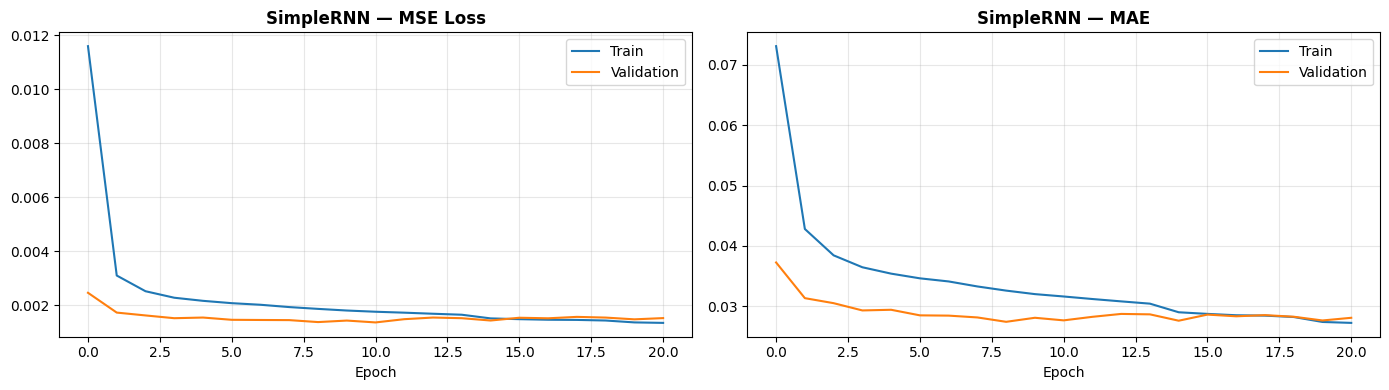

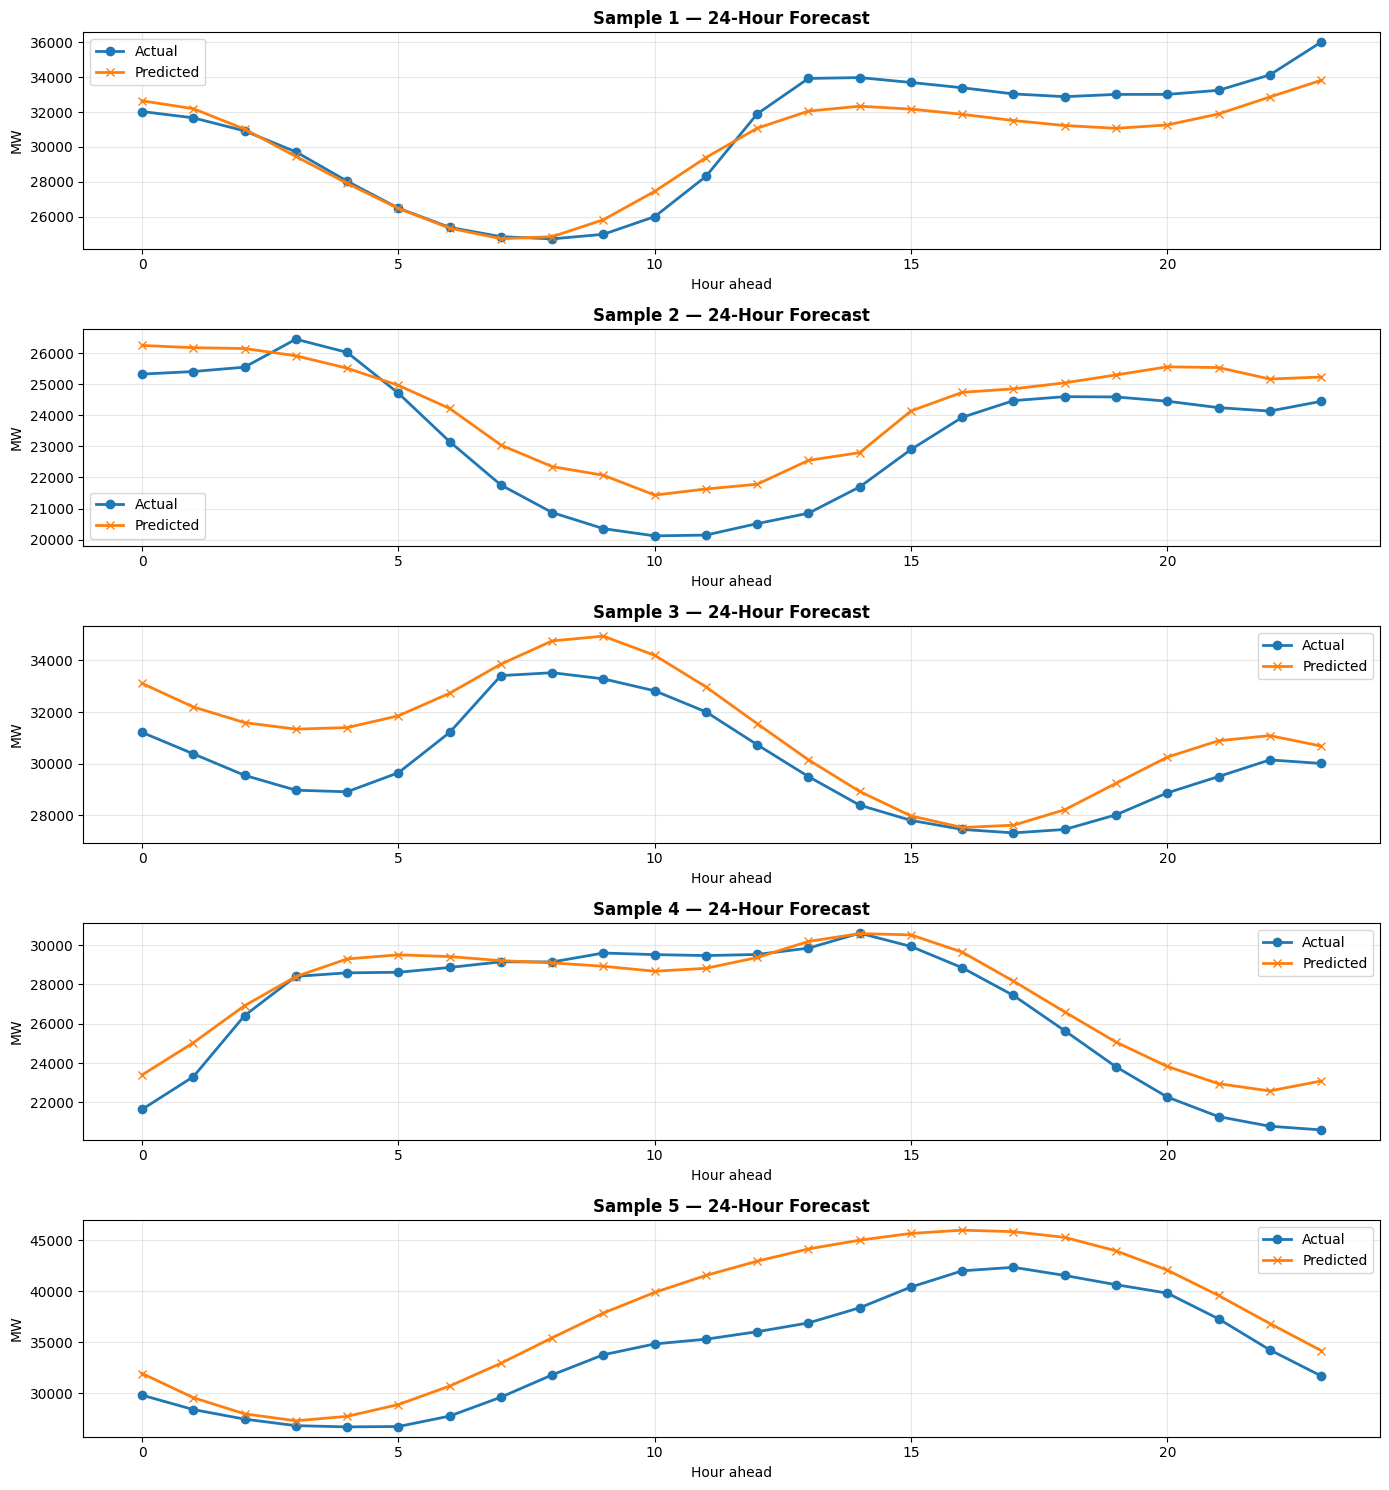


SimpleRNN results:
  RMSE: 1,918.3 MW
  MAE:  1,426.2 MW
  MAPE: 4.58%
  ✓ Saved to saved_models/SimpleRNN.keras

--- Training LSTM ---


c:\Users\wasee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 327s 216ms/step - loss: 0.0044 - mae: 0.0467 - mape: 1963.9282 - val_loss: 0.0018 - val_mae: 0.0313 - val_mape: 9.4415 - learning_rate: 0.0010
Epoch 2/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 207s 139ms/step - loss: 0.0018 - mae: 0.0324 - mape: 1680.7051 - val_loss: 0.0015 - val_mae: 0.0287 - val_mape: 8.6071 - learning_rate: 0.0010
Epoch 3/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 159s 107ms/step - loss: 0.0016 - mae: 0.0303 - mape: 1600.4528 - val_loss: 0.0014 - val_mae: 0.0277 - val_mape: 8.5685 - learning_rate: 0.0010
Epoch 4/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 158s 106ms/step - loss: 0.0015 - mae: 0.0292 - mape: 1637.6504 - val_loss: 0.0014 - val_mae: 0.0269 - val_mape: 8.1840 - learning_rate: 0.0010
Epoch 5/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 155s 104ms/step - loss: 0.0014 - mae: 0.0283 - mape: 1615.1791 - val_loss: 0.0013 - val_mae: 0.0260 - val_mape: 7.8107 - learning_rate: 0.0010
Epoch 6/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 155s 104ms/step - loss: 0.0014 - 

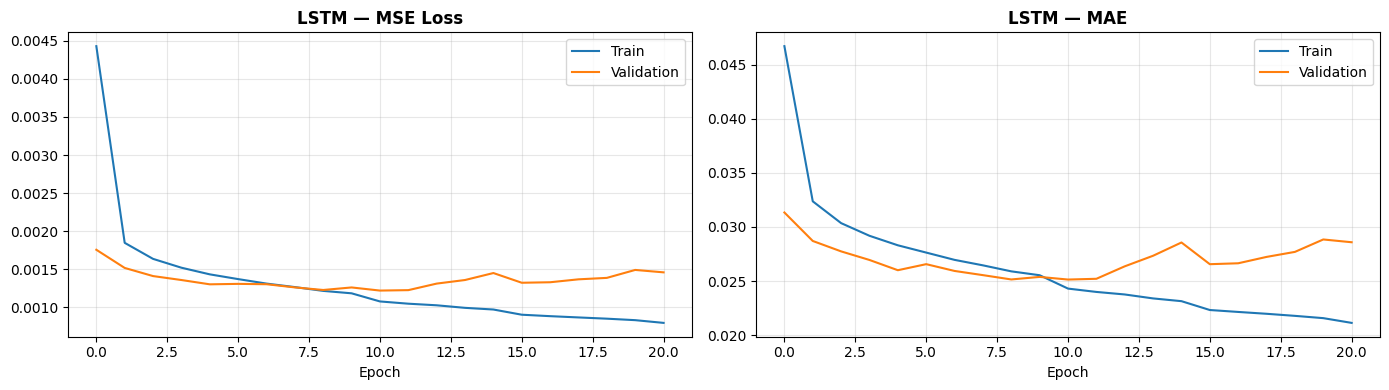

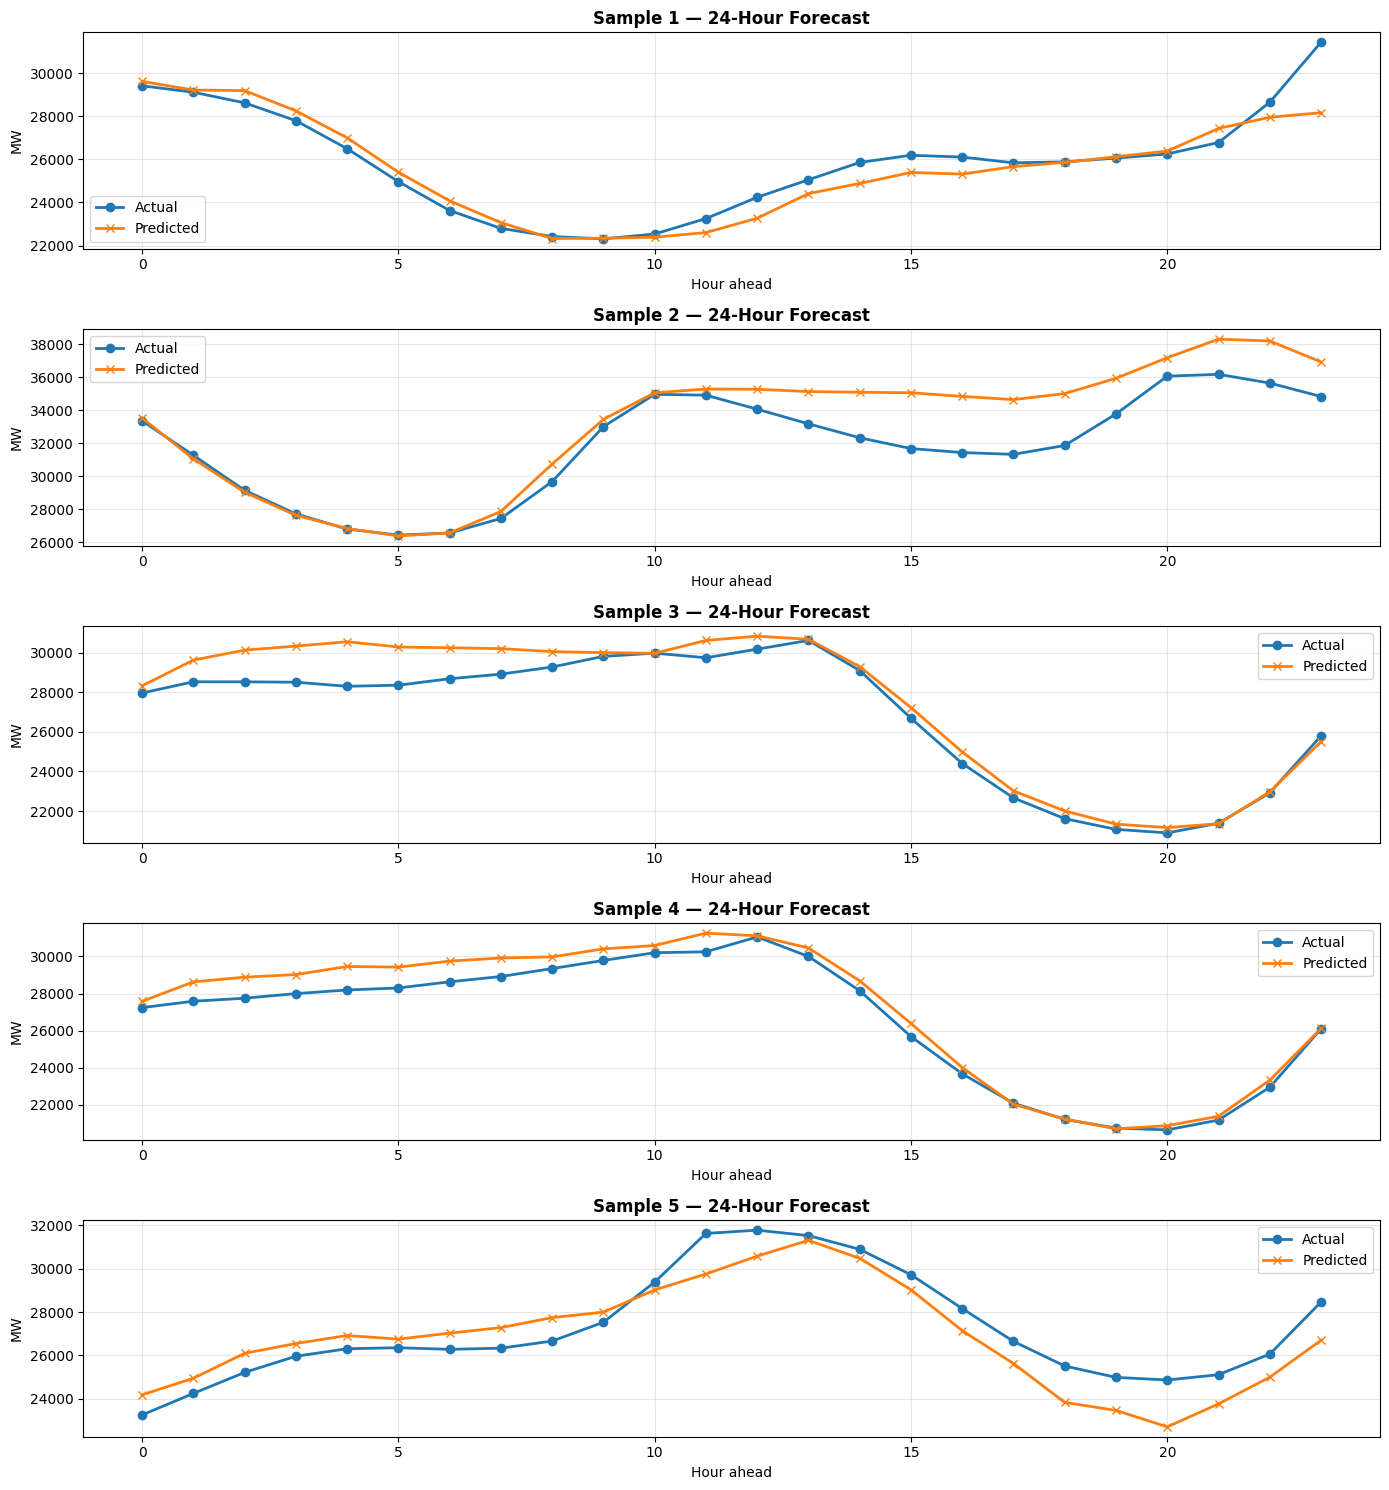


LSTM results:
  RMSE: 1,858.3 MW
  MAE:  1,326.3 MW
  MAPE: 4.20%
  ✓ Saved to saved_models/LSTM.keras

--- Training BiLSTM ---


c:\Users\wasee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 414s 276ms/step - loss: 0.0040 - mae: 0.0442 - mape: 1901.9617 - val_loss: 0.0016 - val_mae: 0.0302 - val_mape: 9.2474 - learning_rate: 0.0010
Epoch 2/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 429s 289ms/step - loss: 0.0017 - mae: 0.0307 - mape: 1656.2743 - val_loss: 0.0015 - val_mae: 0.0285 - val_mape: 8.7004 - learning_rate: 0.0010
Epoch 3/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 436s 293ms/step - loss: 0.0015 - mae: 0.0285 - mape: 1599.6392 - val_loss: 0.0013 - val_mae: 0.0267 - val_mape: 8.0229 - learning_rate: 0.0010
Epoch 4/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 453s 305ms/step - loss: 0.0014 - mae: 0.0274 - mape: 1536.6521 - val_loss: 0.0013 - val_mae: 0.0266 - val_mape: 8.0012 - learning_rate: 0.0010
Epoch 5/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 448s 302ms/step - loss: 0.0013 - mae: 0.0265 - mape: 1440.0890 - val_loss: 0.0013 - val_mae: 0.0257 - val_mape: 7.6883 - learning_rate: 0.0010
Epoch 6/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 459s 309ms/step - loss: 0.0012 - 

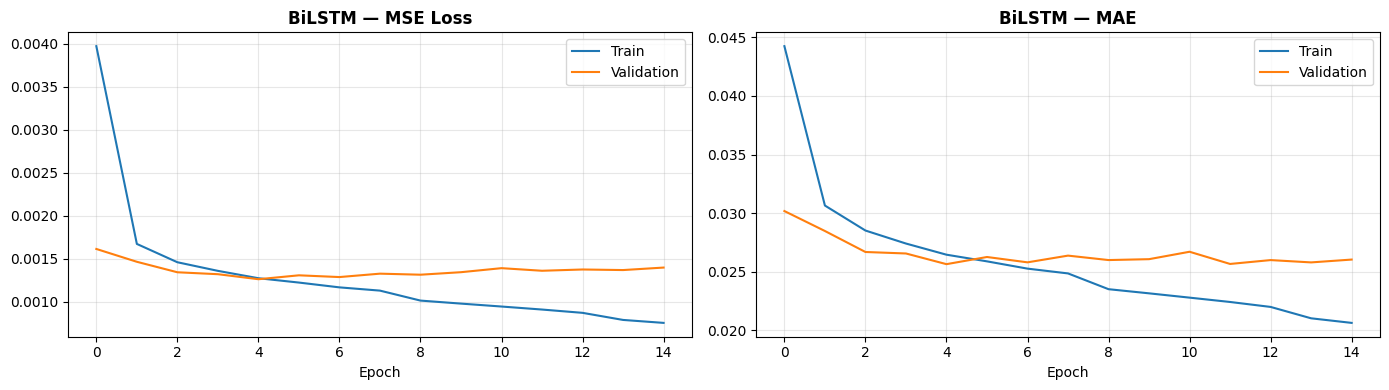

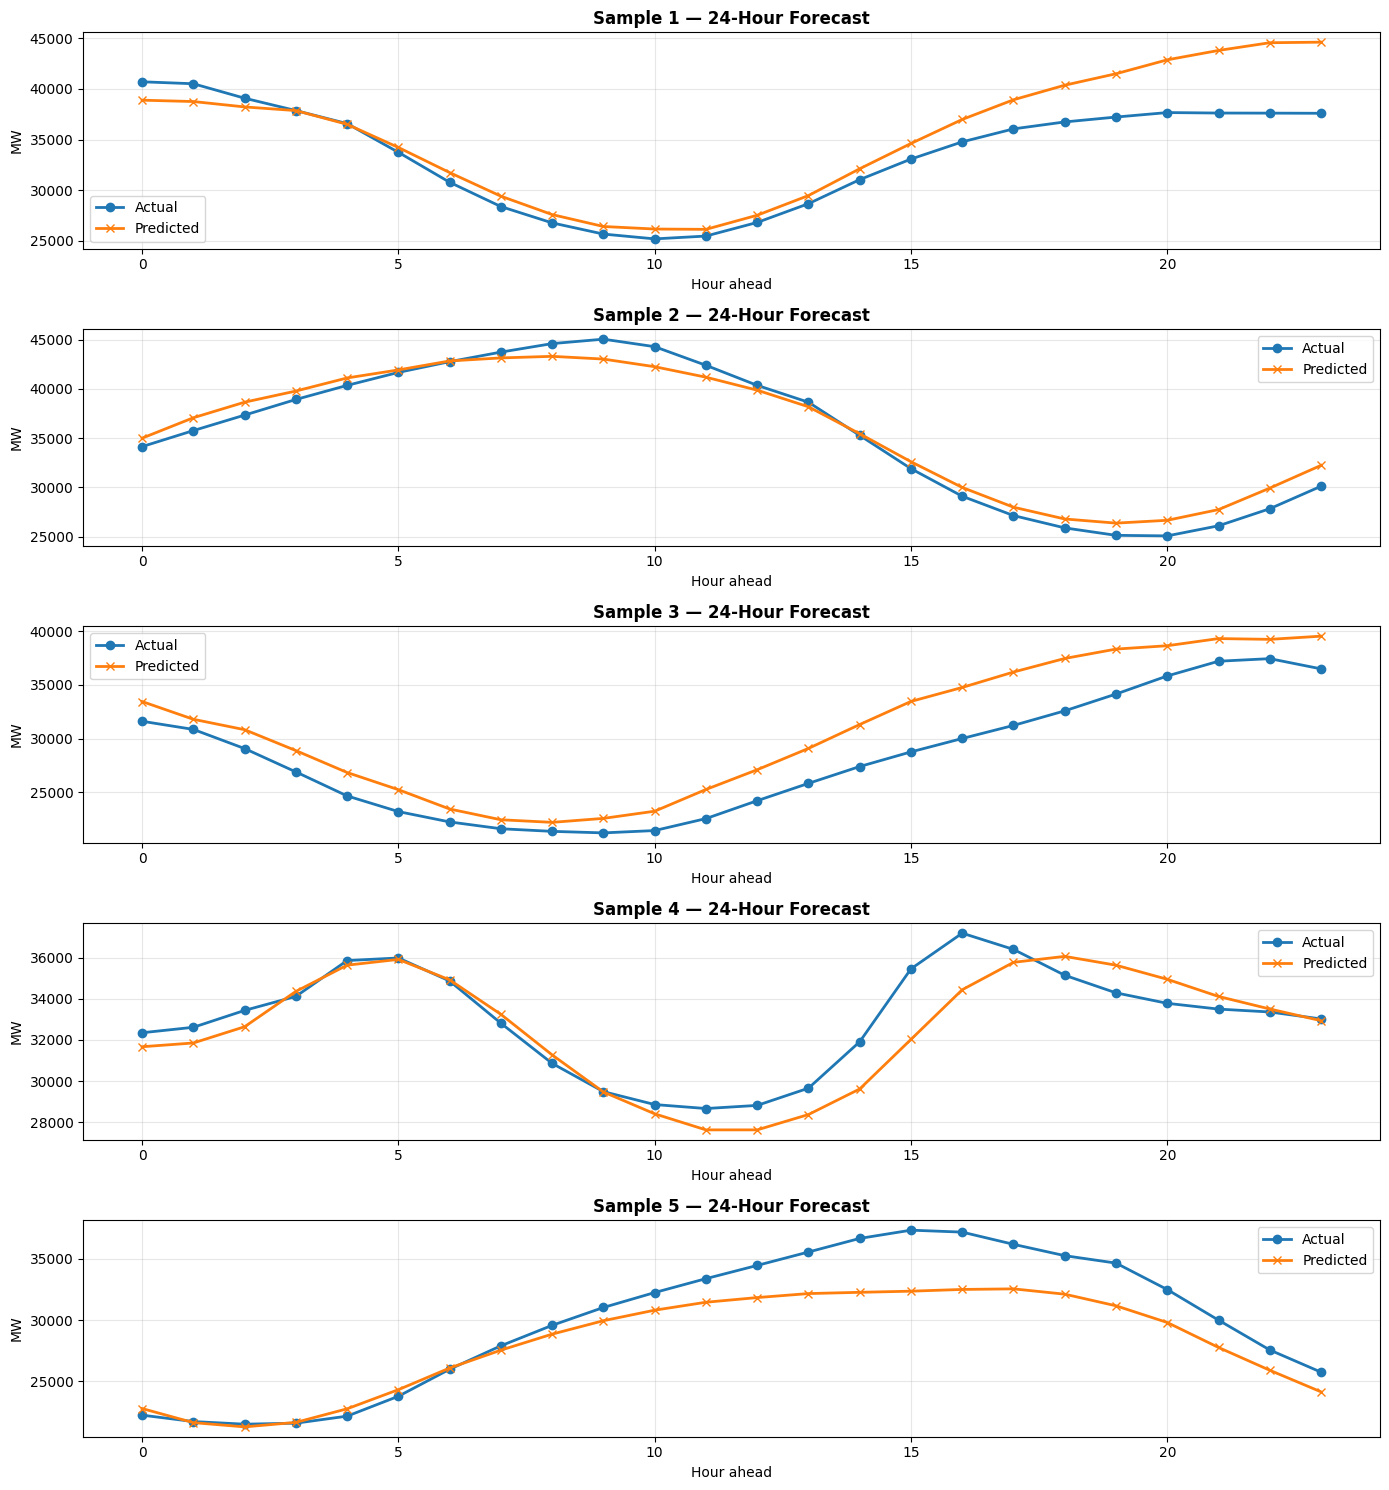


BiLSTM results:
  RMSE: 1,855.3 MW
  MAE:  1,329.1 MW
  MAPE: 4.20%
  ✓ Saved to saved_models/BiLSTM.keras

--- Training EncoderDecoder ---
Epoch 1/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 207s 137ms/step - loss: 0.0036 - mae: 0.0424 - mape: 1931.3995 - val_loss: 0.0017 - val_mae: 0.0304 - val_mape: 9.2431 - learning_rate: 0.0010
Epoch 2/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 197s 132ms/step - loss: 0.0016 - mae: 0.0303 - mape: 1762.5438 - val_loss: 0.0015 - val_mae: 0.0288 - val_mape: 8.7805 - learning_rate: 0.0010
Epoch 3/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - loss: 0.0014 - mae: 0.0279 - mape: 1577.3955 - val_loss: 0.0014 - val_mae: 0.0278 - val_mape: 8.4397 - learning_rate: 0.0010
Epoch 4/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - loss: 0.0013 - mae: 0.0264 - mape: 1542.2629 - val_loss: 0.0013 - val_mae: 0.0262 - val_mape: 7.8743 - learning_rate: 0.0010
Epoch 5/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 194s 131ms/step - loss: 0.0012 - mae: 0.0253 - mape: 1517.3125 - val_loss: 0.

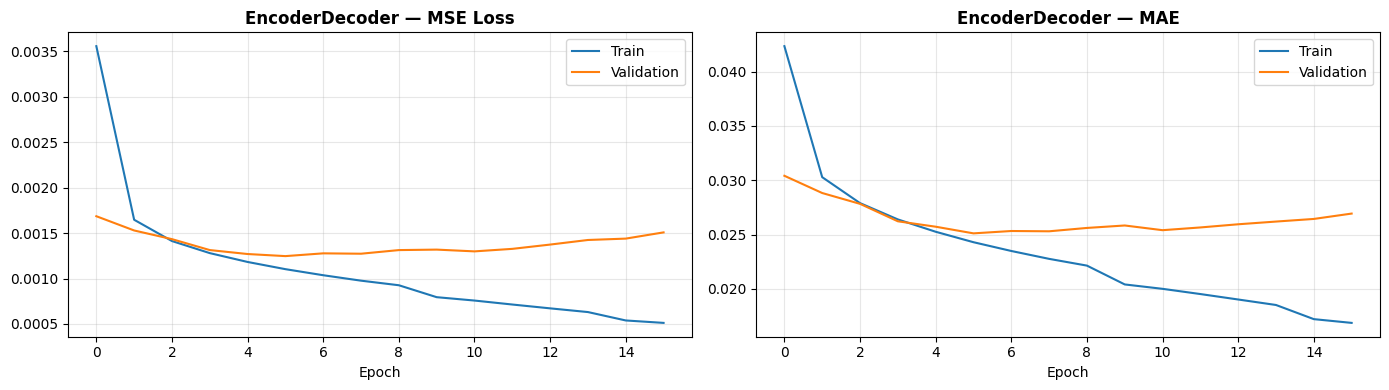

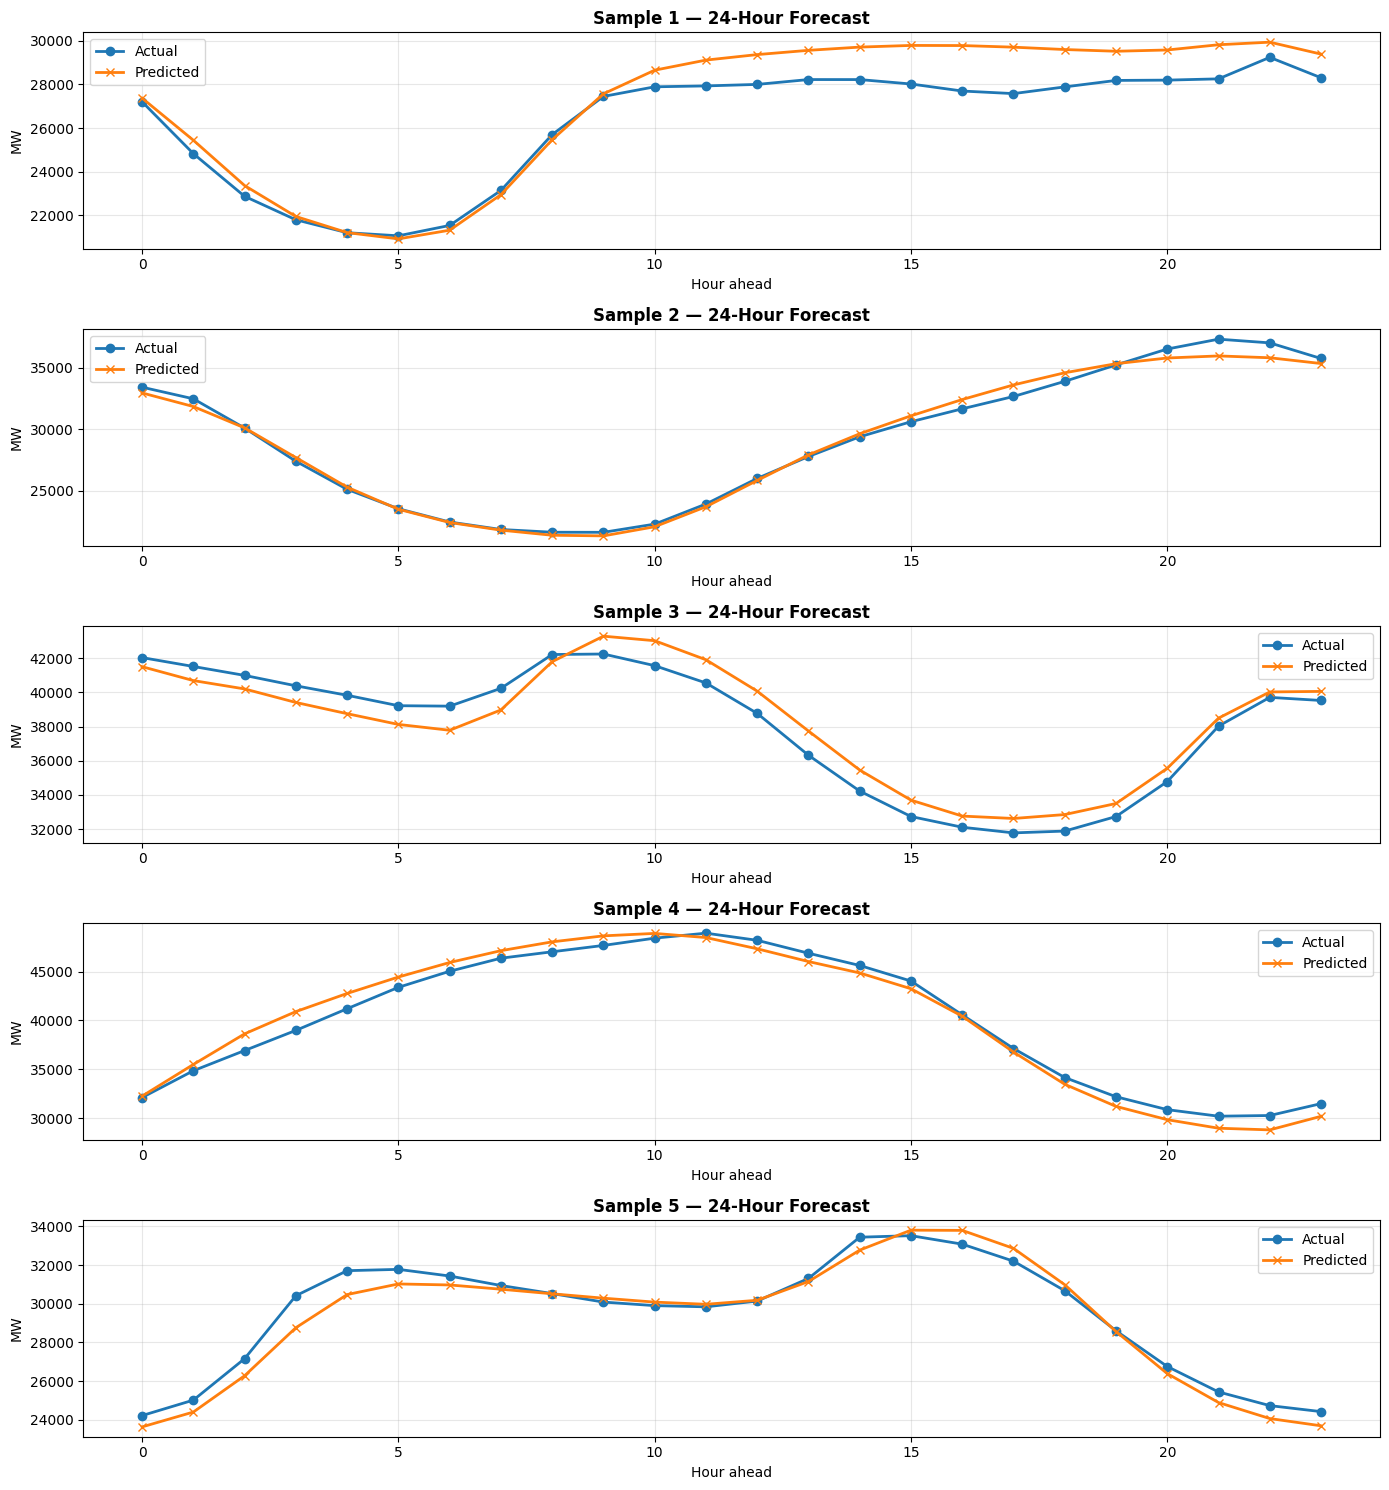


EncoderDecoder results:
  RMSE: 1,883.9 MW
  MAE:  1,321.9 MW
  MAPE: 4.17%
  ✓ Saved to saved_models/EncoderDecoder.keras


In [7]:
all_models = {
    'SimpleRNN':      build_rnn,
    'LSTM':           build_lstm,
    'BiLSTM':         build_bilstm,
    'EncoderDecoder': build_encoder_decoder,
}

results = {}

for name, build_fn in all_models.items():
    model   = build_fn()
    history = train(model, epochs=50, batch_size=64)
    
    plot_history(history, name)
    
    metrics = evaluate(model)
    results[name] = metrics
    
    plot_predictions(metrics['y_true'], metrics['y_pred'], name)
    
    print(f"\n{name} results:")
    print(f"  RMSE: {metrics['RMSE']:,.1f} MW")
    print(f"  MAE:  {metrics['MAE']:,.1f} MW")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  ✓ Saved to saved_models/{name}.keras")

## Model Comparison


FINAL COMPARISON
         Model RMSE (MW) MAE (MW) MAPE (%)
     SimpleRNN    1918.3   1426.2     4.58
          LSTM    1858.3   1326.3     4.20
        BiLSTM    1855.3   1329.1     4.20
EncoderDecoder    1883.9   1321.9     4.17


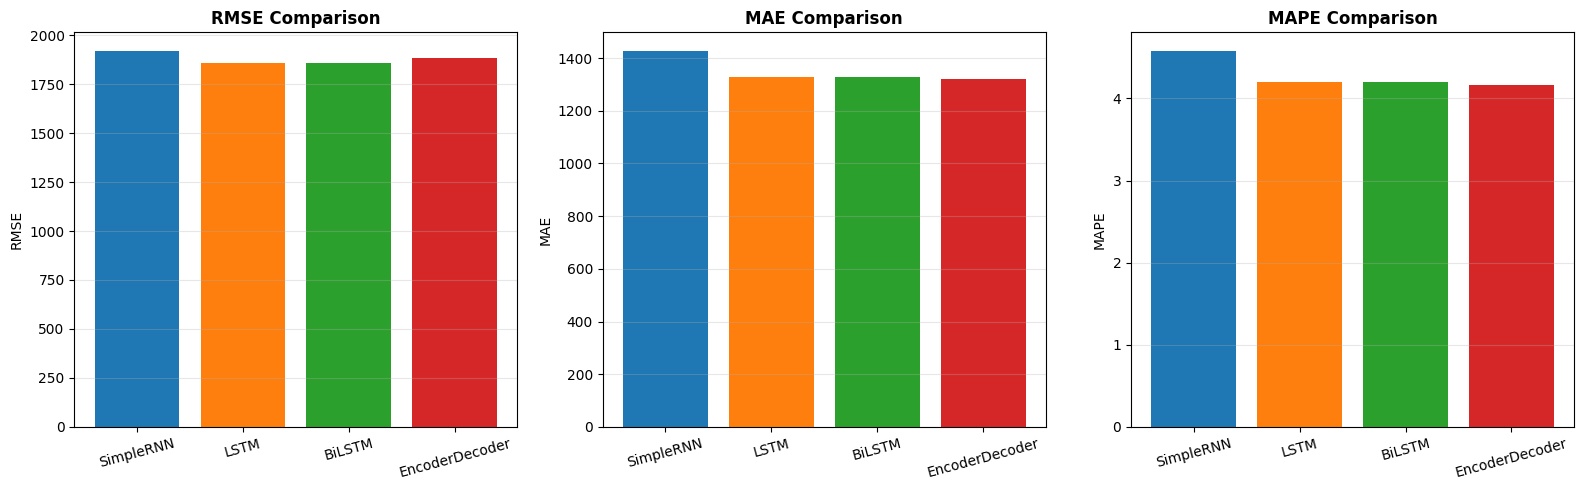


All models saved in 'saved_models/' folder


In [8]:
print("\n" + "="*50)
print("FINAL COMPARISON")
print("="*50)

comparison = pd.DataFrame([
    {'Model': name,
     'RMSE (MW)': f"{m['RMSE']:.1f}",
     'MAE (MW)':  f"{m['MAE']:.1f}",
     'MAPE (%)':  f"{m['MAPE']:.2f}"}
    for name, m in results.items()
])
print(comparison.to_string(index=False))
comparison.to_csv('model_comparison.csv', index=False)

# Bar chart comparing all 3 metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for ax, metric in zip(axes, ['RMSE', 'MAE', 'MAPE']):
    values = [results[n][metric] for n in all_models]
    ax.bar(all_models.keys(), values, color=colors)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAll models saved in 'saved_models/' folder")

## 🎯 Make Predictions Using a Timestamp

Now that models are trained and saved, you can easily make predictions by just providing a date/time.

### How it works:

1. You provide a timestamp (e.g., "2017-05-15 14:00:00")
2. The function automatically loads the previous 168 hours from the dataset
3. Calculates time features automatically
4. Model predicts the next 24 hours
5. Returns predictions AND actual values (so you can see accuracy)

**Note**: The timestamp must be within the test period (2017-03-24 to 2018-08-03) so we have actual data to compare against.

In [9]:
def predict_from_timestamp(model_name, timestamp):
    """
    Make a 24-hour prediction starting from a given timestamp.
    
    Parameters:
    -----------
    model_name : str
        Name of the model to use ('SimpleRNN', 'LSTM', 'BiLSTM', or 'EncoderDecoder')
    
    timestamp : str or pd.Timestamp
        The starting point for prediction (e.g., '2017-05-15 14:00:00')
        Must be within the test period (2017-03-24 to 2018-08-03)
    
    Returns:
    --------
    results : dict
        Dictionary containing:
        - 'prediction': 24-hour forecast for all 5 regions (DataFrame)
        - 'actual': Actual values for comparison (DataFrame)
        - 'metrics': RMSE, MAE, MAPE for this prediction
        - 'input_period': The 168-hour period used as input
    """
    # Load the saved model
    model = models.load_model(f'saved_models/{model_name}.keras')
    print(f"✓ Loaded {model_name}")
    
    # Load the featured dataset
    df = pd.read_csv('pjm_featured.csv')
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    # Convert timestamp to datetime
    target_time = pd.to_datetime(timestamp)
    
    # Find the index of this timestamp
    try:
        target_idx = df[df['Datetime'] == target_time].index[0]
    except IndexError:
        raise ValueError(f"Timestamp {target_time} not found in dataset. "
                        f"Available range: {df['Datetime'].min()} to {df['Datetime'].max()}")
    
    # Check if we have enough history (168 hours before) and future (24 hours after)
    if target_idx < 168:
        raise ValueError(f"Need at least 168 hours before {target_time}. Pick a later date.")
    
    if target_idx + 24 > len(df):
        raise ValueError(f"Need 24 hours after {target_time} for comparison. Pick an earlier date.")
    
    # Get the 168-hour input window
    input_start_idx = target_idx - 168
    input_window = df.iloc[input_start_idx:target_idx]
    
    # Get the 24-hour actual values for comparison
    actual_window = df.iloc[target_idx:target_idx + 24]
    
    print(f"✓ Using data from {input_window['Datetime'].iloc[0]} to {input_window['Datetime'].iloc[-1]}")
    print(f"✓ Predicting from {actual_window['Datetime'].iloc[0]} to {actual_window['Datetime'].iloc[-1]}")
    
    # Feature columns
    feature_cols = ['PJME', 'PJMW', 'DAYTON', 'AEP', 'DUQ', 
                    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 
                    'IsWeekend', 'DayOfWeek']
    
    # Normalize input using the saved scaler
    input_scaled = scaler.transform(input_window[feature_cols].values)
    
    # Reshape for model: (1, 168, 11)
    input_scaled = input_scaled.reshape(1, 168, 11)
    
    # Predict (returns scaled values for PJME only)
    pred_scaled = model.predict(input_scaled, verbose=0)
    
    # Inverse transform to get real MW values
    n_feat = scaler.n_features_in_
    dummy = np.zeros((24, n_feat))
    dummy[:, 0] = pred_scaled[0]  # PJME is first feature
    pred_pjme = scaler.inverse_transform(dummy)[:, 0]
    
    # Get actual values for all 5 regions
    energy_cols = ['PJME', 'PJMW', 'DAYTON', 'AEP', 'DUQ']
    actual_values = actual_window[energy_cols].values
    
    # For now, we only predict PJME (you trained on PJME as target)
    # Create results dataframe
    results_df = pd.DataFrame({
        'Datetime': actual_window['Datetime'].values,
        'Hour': range(1, 25),
        'Predicted_PJME': pred_pjme,
        'Actual_PJME': actual_values[:, 0],
        'Actual_PJMW': actual_values[:, 1],
        'Actual_DAYTON': actual_values[:, 2],
        'Actual_AEP': actual_values[:, 3],
        'Actual_DUQ': actual_values[:, 4],
    })
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual_values[:, 0], pred_pjme))
    mae = mean_absolute_error(actual_values[:, 0], pred_pjme)
    mape = mean_absolute_percentage_error(actual_values[:, 0], pred_pjme) * 100
    
    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
    
    print(f"\n📊 Prediction Metrics:")
    print(f"  RMSE: {rmse:,.1f} MW")
    print(f"  MAE:  {mae:,.1f} MW")
    print(f"  MAPE: {mape:.2f}%")
    
    return {
        'prediction': results_df,
        'metrics': metrics,
        'input_period': (input_window['Datetime'].iloc[0], input_window['Datetime'].iloc[-1]),
        'forecast_period': (actual_window['Datetime'].iloc[0], actual_window['Datetime'].iloc[-1])
    }

### Example: Predict from a timestamp

In [10]:
# Pick any date from the test period (2017-03-24 to 2018-08-03)
test_timestamp = '2017-05-15 14:00:00'

# Make prediction using LSTM model
result = predict_from_timestamp('LSTM', test_timestamp)

# Display the results
print("\n📋 Prediction Results:")
print(result['prediction'][['Hour', 'Predicted_PJME', 'Actual_PJME']].head(10))

✓ Loaded LSTM
✓ Using data from 2017-05-08 14:00:00 to 2017-05-15 13:00:00
✓ Predicting from 2017-05-15 14:00:00 to 2017-05-16 13:00:00


c:\Users\wasee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



📊 Prediction Metrics:
  RMSE: 479.3 MW
  MAE:  402.4 MW
  MAPE: 1.52%

📋 Prediction Results:
   Hour  Predicted_PJME  Actual_PJME
0     1    28415.710256      27627.0
1     2    28144.543376      27646.0
2     3    27952.766253      27730.0
3     4    27993.487400      28159.0
4     5    28482.436807      28619.0
5     6    28982.781968      28698.0
6     7    29409.613485      28709.0
7     8    29320.242542      29413.0
8     9    27984.804786      28625.0
9    10    26269.654041      26243.0


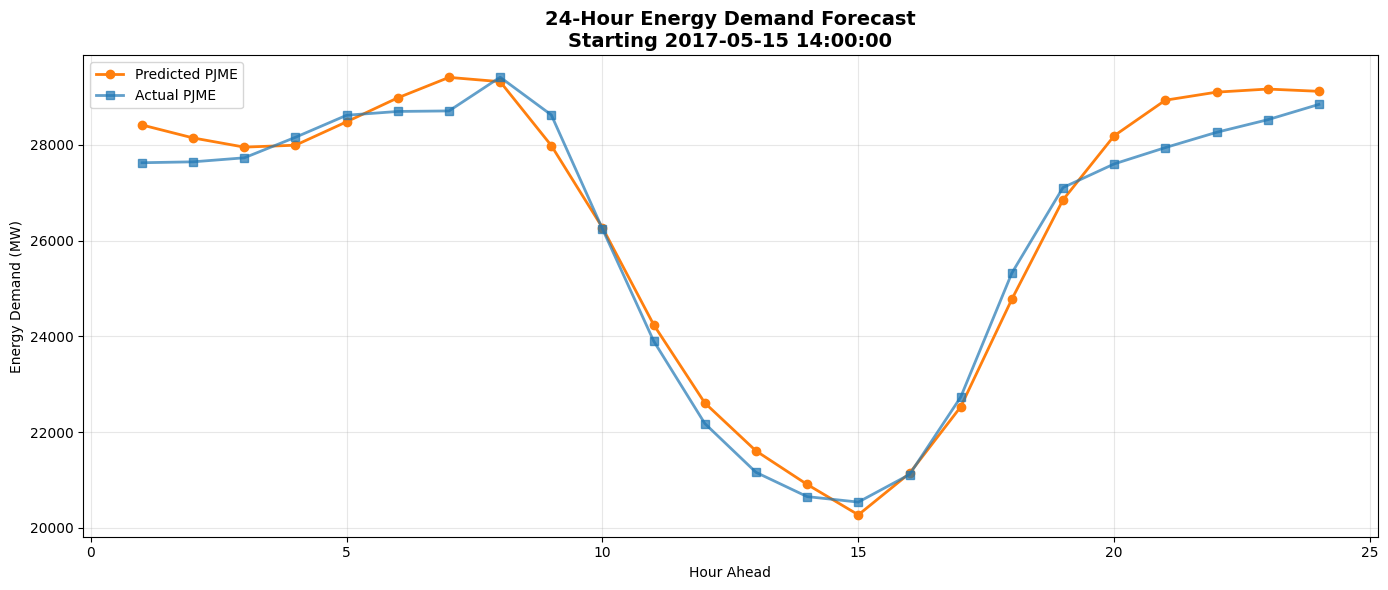


Metrics for this prediction:
  RMSE: 479.3 MW
  MAE:  402.4 MW
  MAPE: 1.52%


In [11]:
# Visualize the prediction
df_result = result['prediction']

plt.figure(figsize=(14, 6))
plt.plot(df_result['Hour'], df_result['Predicted_PJME'], 
         marker='o', linewidth=2, label='Predicted PJME', color='#ff7f0e')
plt.plot(df_result['Hour'], df_result['Actual_PJME'], 
         marker='s', linewidth=2, label='Actual PJME', color='#1f77b4', alpha=0.7)
plt.title(f'24-Hour Energy Demand Forecast\nStarting {test_timestamp}', 
          fontweight='bold', fontsize=14)
plt.xlabel('Hour Ahead')
plt.ylabel('Energy Demand (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMetrics for this prediction:")
print(f"  RMSE: {result['metrics']['RMSE']:,.1f} MW")
print(f"  MAE:  {result['metrics']['MAE']:,.1f} MW")
print(f"  MAPE: {result['metrics']['MAPE']:.2f}%")

### Compare all models on the same timestamp

✓ Loaded SimpleRNN
✓ Using data from 2017-08-13 10:00:00 to 2017-08-20 09:00:00
✓ Predicting from 2017-08-20 10:00:00 to 2017-08-21 09:00:00


c:\Users\wasee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



📊 Prediction Metrics:
  RMSE: 1,325.6 MW
  MAE:  1,163.3 MW
  MAPE: 3.48%
✓ Loaded LSTM
✓ Using data from 2017-08-13 10:00:00 to 2017-08-20 09:00:00
✓ Predicting from 2017-08-20 10:00:00 to 2017-08-21 09:00:00


c:\Users\wasee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



📊 Prediction Metrics:
  RMSE: 749.3 MW
  MAE:  591.7 MW
  MAPE: 1.76%
✓ Loaded BiLSTM
✓ Using data from 2017-08-13 10:00:00 to 2017-08-20 09:00:00
✓ Predicting from 2017-08-20 10:00:00 to 2017-08-21 09:00:00


c:\Users\wasee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



📊 Prediction Metrics:
  RMSE: 988.9 MW
  MAE:  887.2 MW
  MAPE: 2.76%
✓ Loaded EncoderDecoder
✓ Using data from 2017-08-13 10:00:00 to 2017-08-20 09:00:00
✓ Predicting from 2017-08-20 10:00:00 to 2017-08-21 09:00:00


c:\Users\wasee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



📊 Prediction Metrics:
  RMSE: 1,234.7 MW
  MAE:  1,061.5 MW
  MAPE: 3.28%


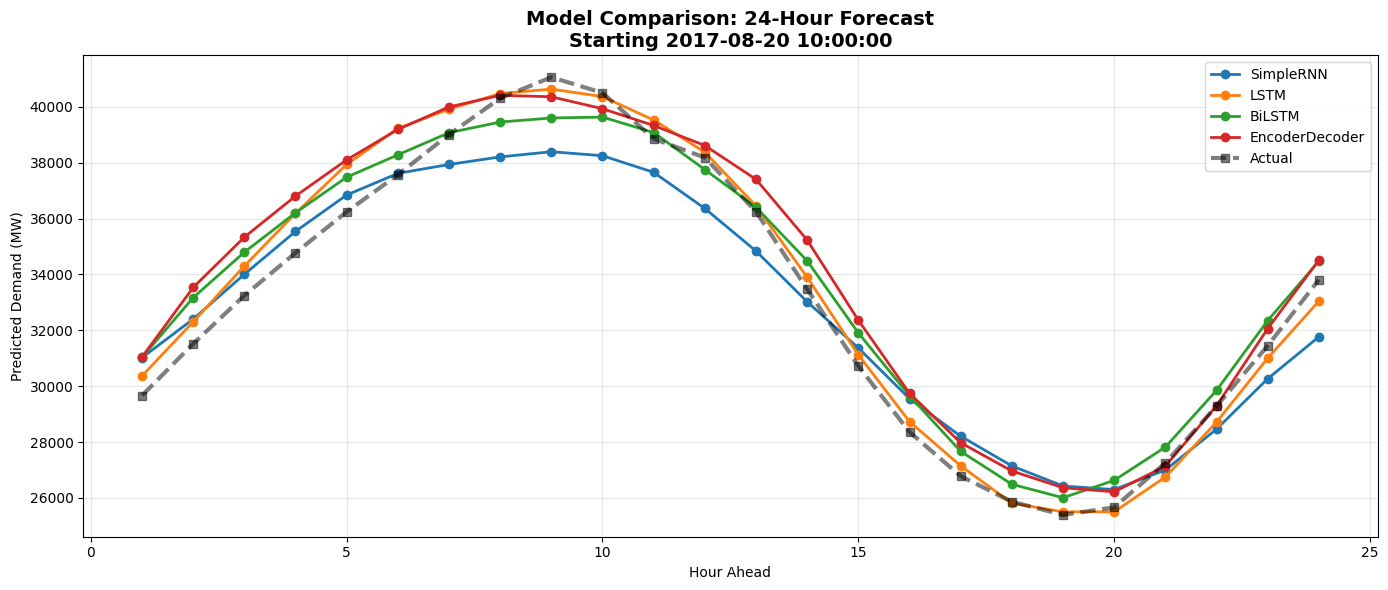

In [12]:
# Compare predictions from all 4 models on the same timestamp
test_timestamp = '2017-08-20 10:00:00'

plt.figure(figsize=(14, 6))

# Store first result to get actual values
actual_values = None

for model_name in ['SimpleRNN', 'LSTM', 'BiLSTM', 'EncoderDecoder']:
    result = predict_from_timestamp(model_name, test_timestamp)
    df_result = result['prediction']
    
    plt.plot(df_result['Hour'], df_result['Predicted_PJME'], 
             marker='o', linewidth=2, label=model_name)
    
    if actual_values is None:
        actual_values = df_result['Actual_PJME']

# Plot actual values
plt.plot(df_result['Hour'], actual_values, 
         marker='s', linewidth=3, label='Actual', color='black', alpha=0.5, linestyle='--')

plt.title(f'Model Comparison: 24-Hour Forecast\nStarting {test_timestamp}', 
          fontweight='bold', fontsize=14)
plt.xlabel('Hour Ahead')
plt.ylabel('Predicted Demand (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 💾 Summary: Your Saved Files

After running this notebook, you'll have:

**Trained Models** (in `saved_models/` folder):
- `SimpleRNN.keras`
- `LSTM.keras`
- `BiLSTM.keras`
- `EncoderDecoder.keras`

**Plots**:
- `training_history_[model].png` (4 files)
- `predictions_[model].png` (4 files)
- `model_comparison.png`

**Results**:
- `model_comparison.csv`

**To reuse a model later**, just run:
```python
from tensorflow.keras import models
model = models.load_model('saved_models/LSTM.keras')
```